In [61]:
%reload_ext autoreload
%autoreload 2

import os
from scipy.stats import truncnorm
import pickle

import corner
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline   

from models_streams import *
from models_orbits import *
from priors import *
from utils import *
from mock_data import *
from likelihoods import *
from dynesty_fit import dynesty_fit
from corner_plots import *

In [62]:
q_mean, q_sig, nlive, sigma, N, seed = 1.0, 0.1, 4000, 5, 100, 41
PATH_SAVE  = f'/data/dc824-2/final_orbit_to_stream/q{q_mean}_qsig{q_sig}_seed{seed}_nlive{nlive}_sigma{sigma}'
id = 4
save_stream = f'{PATH_SAVE}/xx_{id+1:03d}'

with open(f'{save_stream}/dict_data.pkl', 'rb') as file:
        dict_data = pickle.load(file)
params_data = np.loadtxt(f'{save_stream}/params.txt')
theta_initial = dict_data['theta'][0]

In [63]:
theta_initial

5.977752688080578

[  12.78458     7.476504    0.933405   -1.23399     0.923397    0.254466    7.768081    2.031741 -100.950592  -29.658319  -28.254122    2.825465   -0.07441    -0.396297   -0.105665    4.632414]


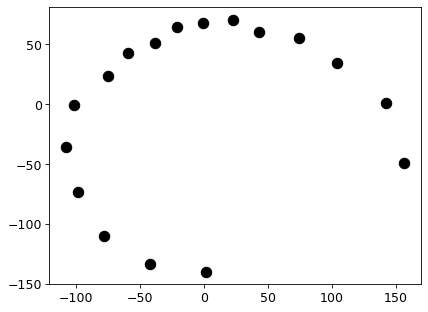

In [64]:
print(params_data)
plt.scatter(dict_data['x'], dict_data['y'], s=100, color='k', label='Stream Data')

In [65]:
model_info = {
    'model': gala_orbit_model_ndim12,
    'prior_transform': orbit_large_prior_transform_ndim12,
    'model_spline': orbit_spline,
    'log_likelihood': model_log_likelihood,
    'ndim': 12
}


In [66]:
p = np.random.uniform(size=model_info['ndim'])
params = model_info['prior_transform'](p)
logl = model_info['log_likelihood'](params, dict_data, model_info['model'], model_info['model_spline'], 0)

In [67]:
nlive = 1000
dict_result = dynesty_fit(dict_data, 
                model_info['model'],
                model_info['model_spline'],
                model_info['log_likelihood'],
                model_info['prior_transform'],
                ndim=model_info['ndim'], nlive=nlive, theta_initial=theta_initial)

27731it [02:38, 174.69it/s, batch: 1 | bound: 6 | nc: 1 | ncall: 1981501 | eff(%):  1.345 | loglstar: -8.765 < -4.578 < -6.424 | logz: -23.466 +/-  0.130 | stop:  0.991]                


### Fit for Data with ID 4 ###

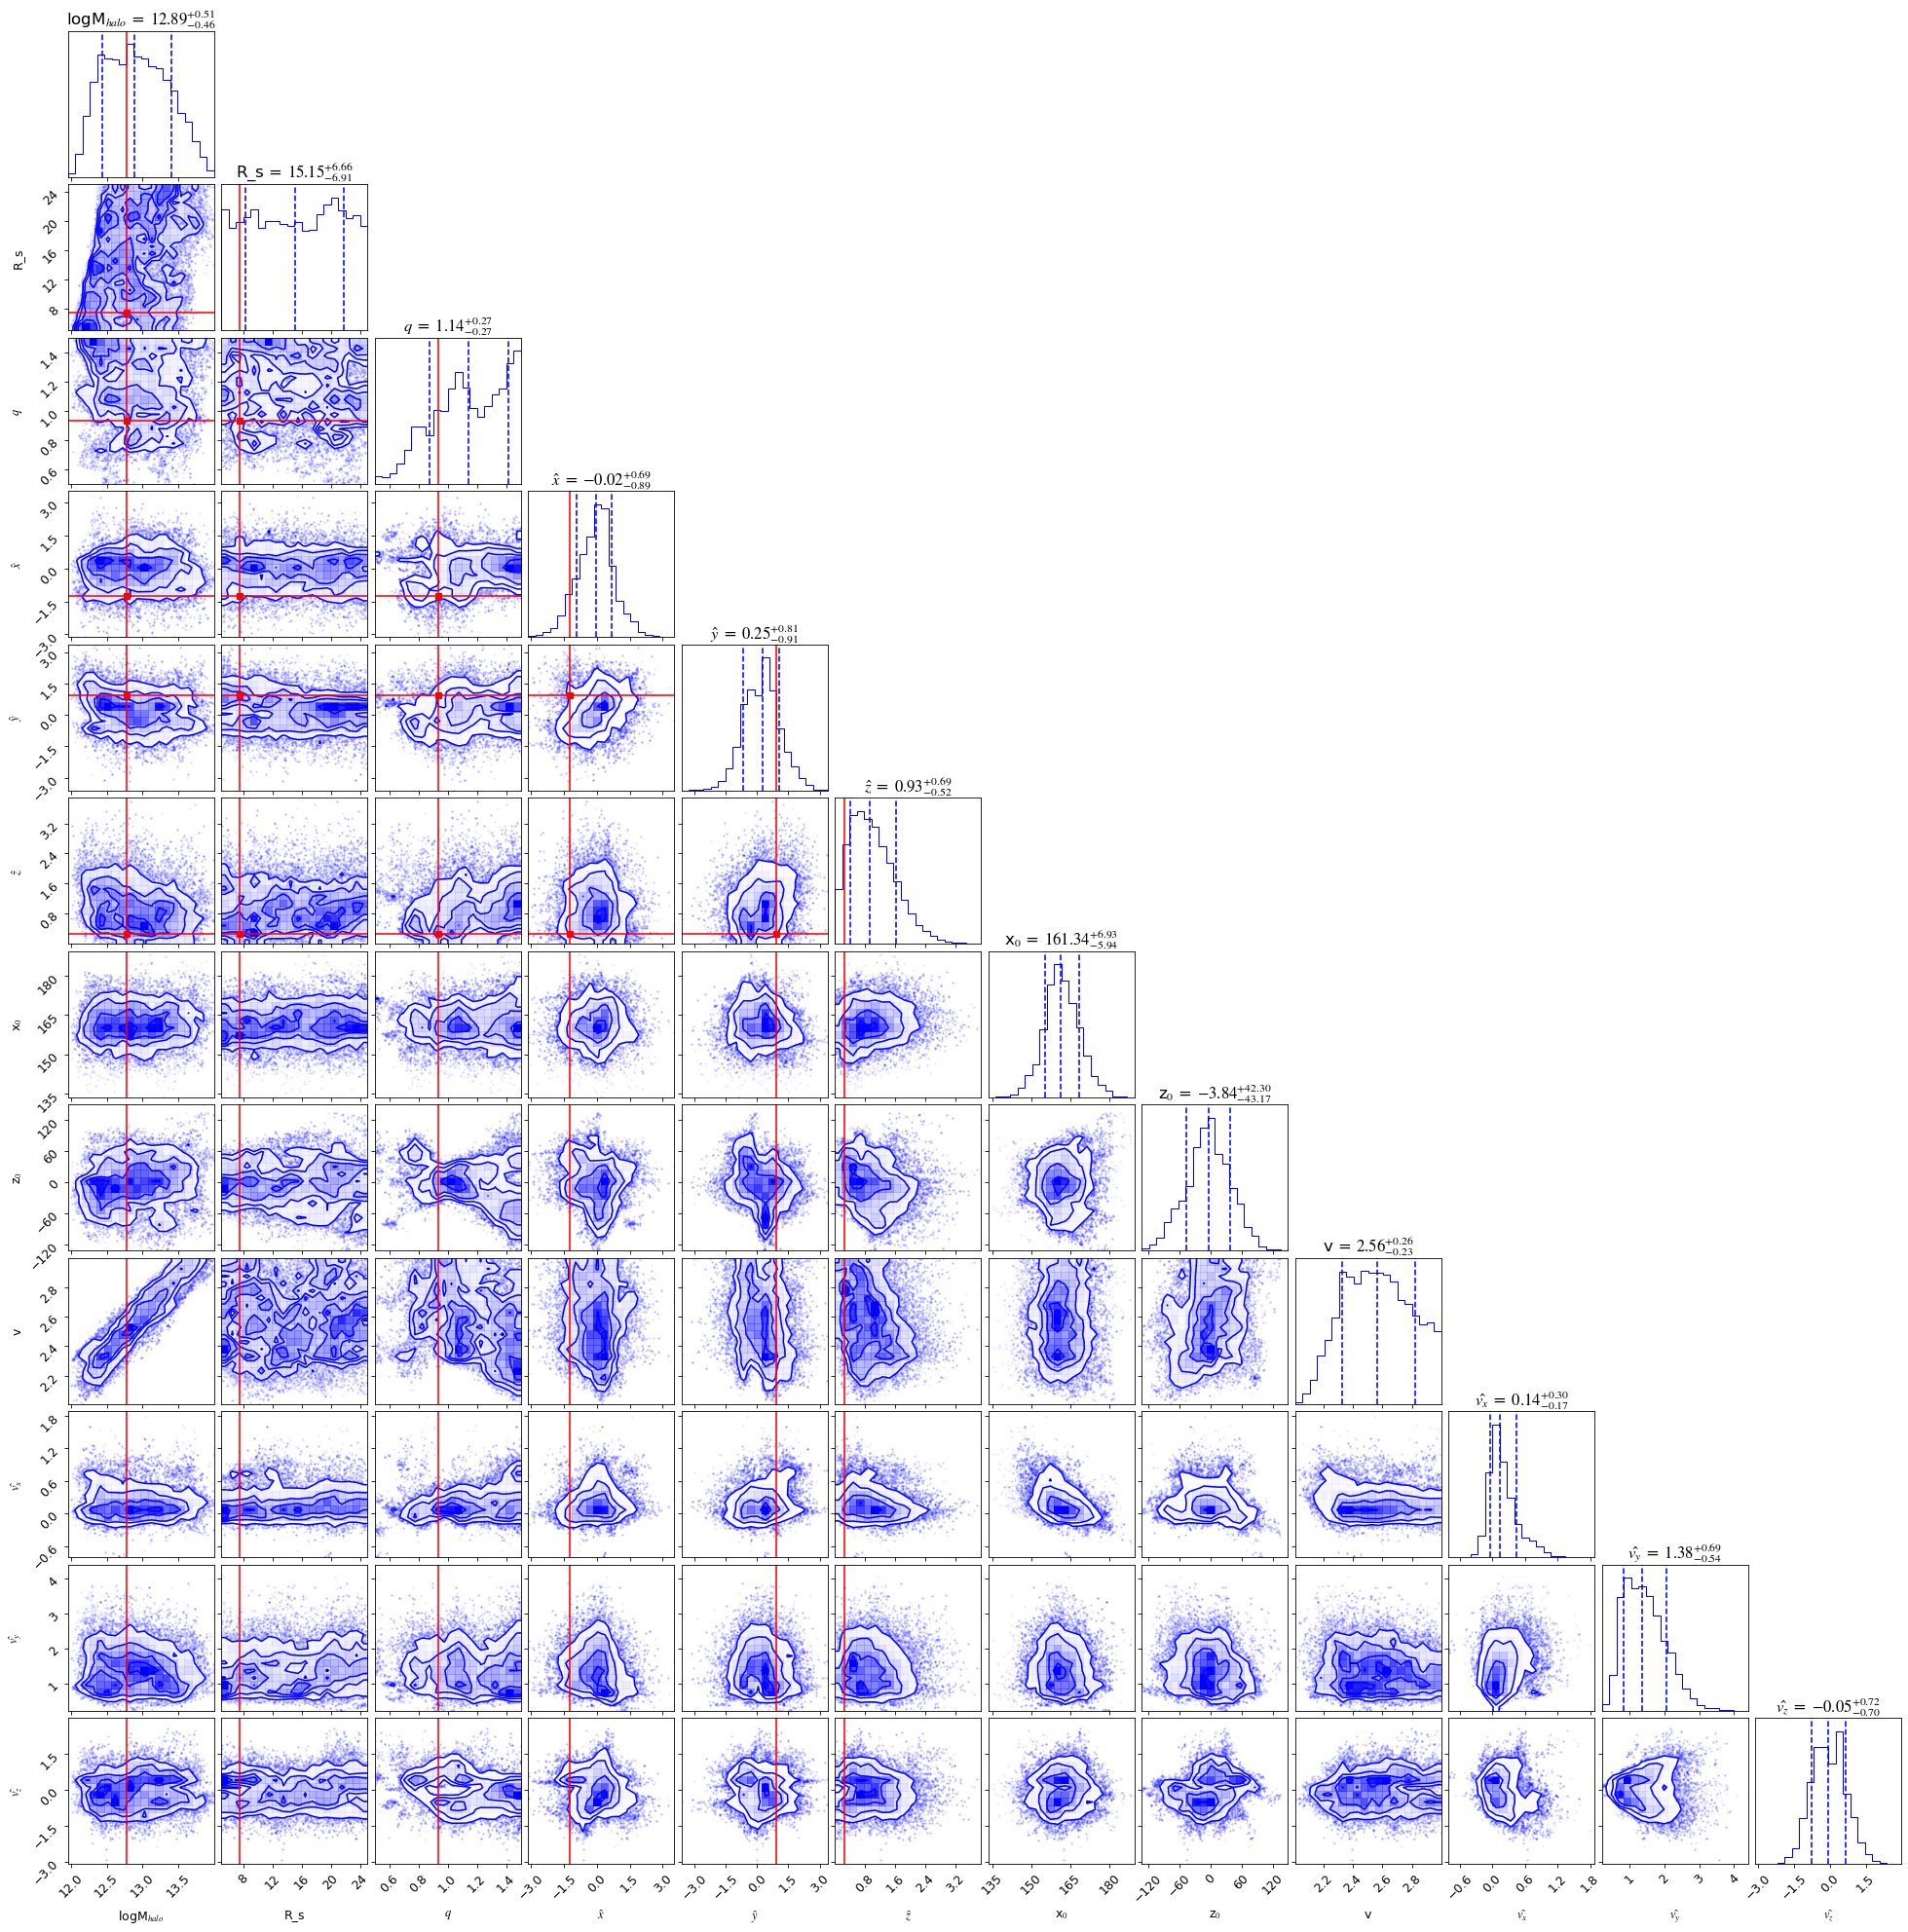

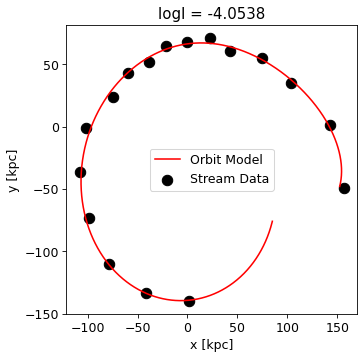

In [52]:
from corner_plots import *
labels=[r'logM$_{halo}$', r'R_s', r'$q$', r'$\hat{x}$', r'$\hat{y}$', r'$\hat{z}$', 
                                r'x$_0$', r'z$_0$', r'v', r'$\hat{v_x}$', r'$\hat{v_y}$', r'$\hat{v_z}$']
ground_truth = np.concatenate([params_data[:6], np.zeros(6)+np.nan])    

figure = corner.corner(dict_result['samps'], 
            labels=labels,
            color='blue',
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True, 
            title_kwargs={"fontsize": 16},
            truths=ground_truth, 
            truth_color='red')


plt.figure(figsize=(5, 5))
plt.xlabel(r'x [kpc]')
plt.ylabel(r'y [kpc]')
xyz_model, xyz_prog = model_info['model'](dict_result['samps'][np.argmax(dict_result['logl'])], theta_initial=theta_initial)
plt.title(f'logl = {np.max(dict_result["logl"]):.4f}')
x_model, y_model = xyz_model[:,0], xyz_model[:,1]
plt.plot(x_model, y_model, color='red', label='Orbit Model')
plt.scatter(dict_data['x'], dict_data['y'], s=100, color='k', label='Stream Data')
plt.legend(loc='best')

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.update_layout(title='Flattening free')

# Plot the stream
xyz_stream, xyz_prog = gala_stream_model_ndim16(params_data)
fig.add_trace(go.Scatter3d(
    x=xyz_stream[:, 0], 
    y=xyz_stream[:, 1], 
    z=xyz_stream[:, 2], 
    mode='markers', 
    marker=dict(size=5, color='blue'),
    name='Stream'
))

# Plot the final position of the progenitor on top
fig.add_trace(go.Scatter3d(
    x=[xyz_prog[0]], 
    y=[xyz_prog[1]], 
    z=[xyz_prog[2]], 
    mode='markers', 
    marker=dict(size=20, color='black'),
    name='Progenitor'
))

# Normalize the direction vector
d = params_data[3:6]
d_norm = np.linalg.norm(d)
if d_norm == 0:
    raise ValueError("Direction vector must be nonzero.")
d = d / d_norm

# Add a thick green line with orientation (dirx, diry, dirz)
fig.add_trace(go.Scatter3d(
    x=[-d[0] * 200, d[0] * 200], 
    y=[-d[1] * 200, d[1] * 200], 
    z=[-d[2] * 200, d[2] * 200], 
    mode='lines', 
    line=dict(color='green', width=10),
    showlegend=False
))

xyz_model, xyz_prog = model_info['model'](dict_result['samps'][np.argmax(dict_result['logl'])], theta_initial=theta_initial)
fig.add_trace(go.Scatter3d(
    x=xyz_model[:, 0], 
    y=xyz_model[:, 1], 
    z=xyz_model[:, 2], 
    mode='markers', 
    marker=dict(size=5, color='red'),
    name='Best Fit Orbit'
))

# Normalize the direction vector
d = dict_result['samps'][np.argmax(dict_result['logl'])][3:6]
d_norm = np.linalg.norm(d)
if d_norm == 0:
    raise ValueError("Direction vector must be nonzero.")
d = d / d_norm

# Add a thick green line with orientation (dirx, diry, dirz)
fig.add_trace(go.Scatter3d(
    x=[-d[0] * 200, d[0] * 200], 
    y=[-d[1] * 200, d[1] * 200], 
    z=[-d[2] * 200, d[2] * 200], 
    mode='lines', 
    line=dict(color='orange', width=10),
    showlegend=False
))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    width=800,
    height=600
)

fig.show()

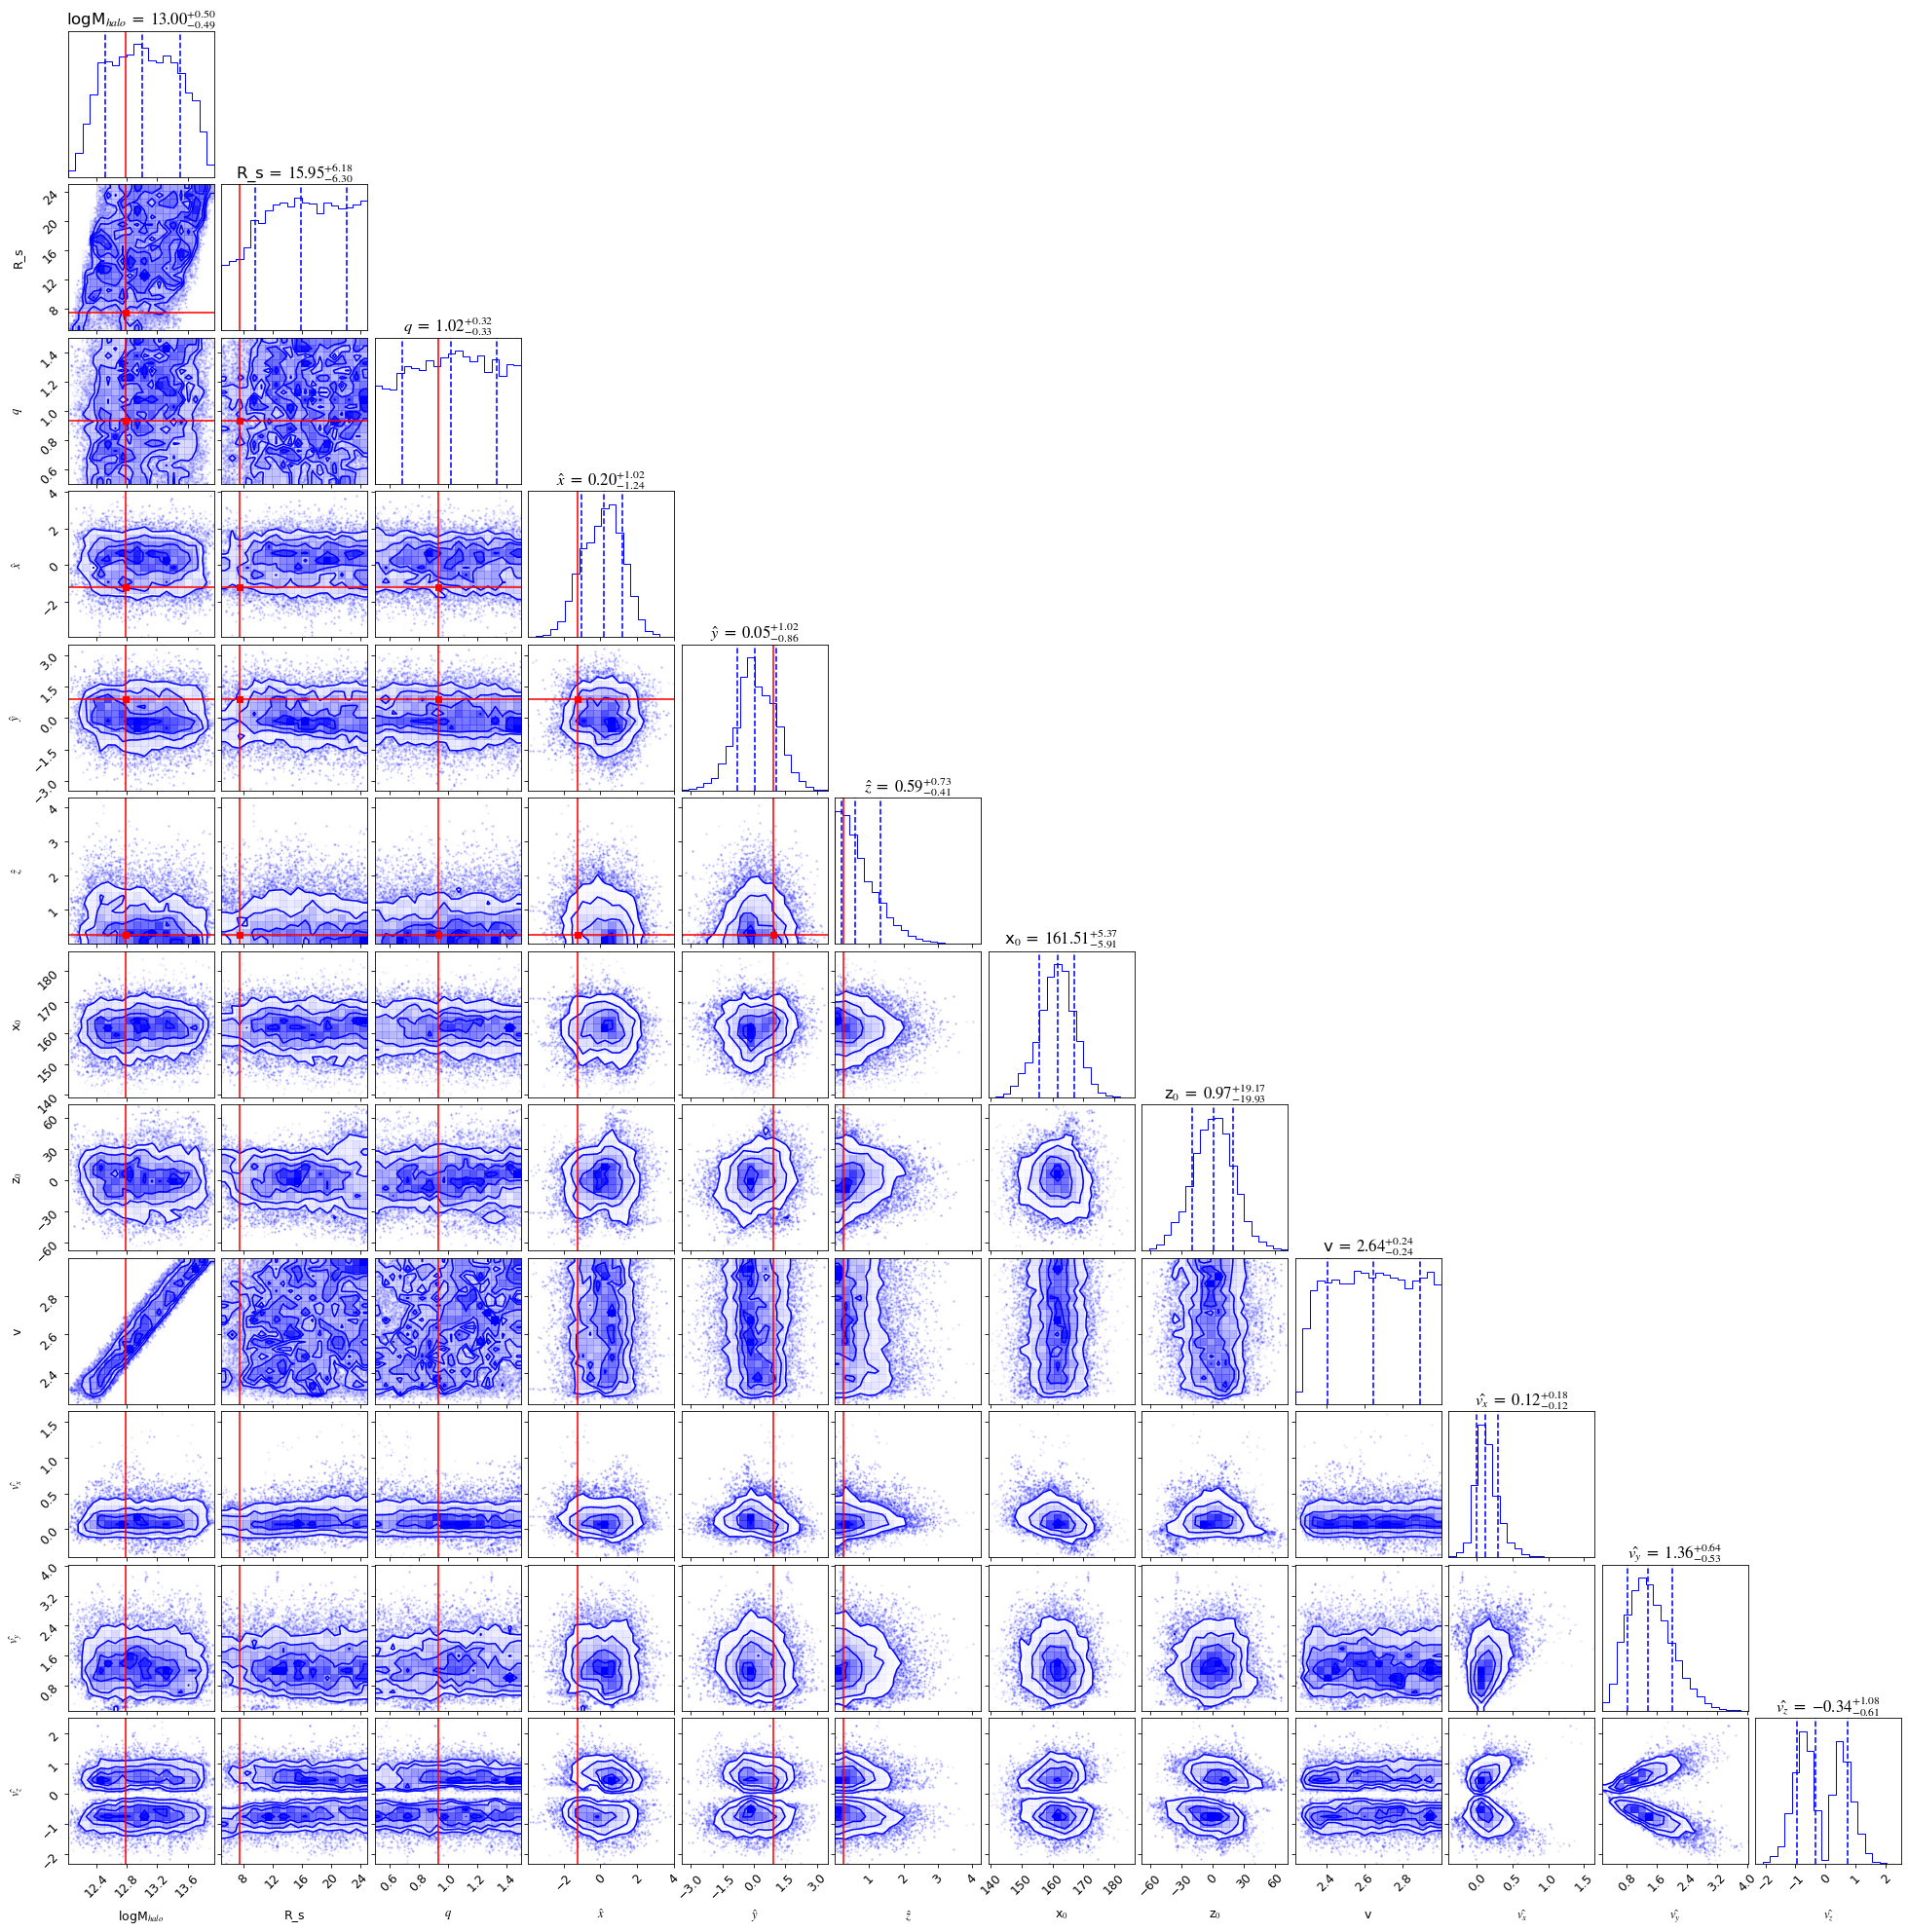

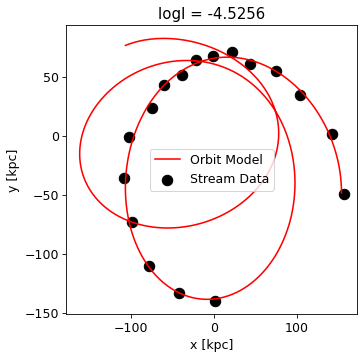

In [68]:
from corner_plots import *
labels=[r'logM$_{halo}$', r'R_s', r'$q$', r'$\hat{x}$', r'$\hat{y}$', r'$\hat{z}$', 
                                r'x$_0$', r'z$_0$', r'v', r'$\hat{v_x}$', r'$\hat{v_y}$', r'$\hat{v_z}$']
ground_truth = np.concatenate([params_data[:6], np.zeros(6)+np.nan])    

figure = corner.corner(dict_result['samps'], 
            labels=labels,
            color='blue',
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True, 
            title_kwargs={"fontsize": 16},
            truths=ground_truth, 
            truth_color='red')


plt.figure(figsize=(5, 5))
plt.xlabel(r'x [kpc]')
plt.ylabel(r'y [kpc]')
xyz_model, xyz_prog = model_info['model'](dict_result['samps'][np.argmax(dict_result['logl'])], theta_initial=theta_initial)
plt.title(f'logl = {np.max(dict_result["logl"]):.4f}')
x_model, y_model = xyz_model[:,0], xyz_model[:,1]
plt.plot(x_model, y_model, color='red', label='Orbit Model')
plt.scatter(dict_data['x'], dict_data['y'], s=100, color='k', label='Stream Data')
plt.legend(loc='best')

In [70]:
import plotly.graph_objects as go

fig = go.Figure()

fig.update_layout(title='Fixed at correct flattening')
# Plot the stream
xyz_stream, xyz_prog = gala_stream_model_ndim16(params_data)
fig.add_trace(go.Scatter3d(
    x=xyz_stream[:, 0], 
    y=xyz_stream[:, 1], 
    z=xyz_stream[:, 2], 
    mode='markers', 
    marker=dict(size=5, color='blue'),
    name='Stream'
))

# Plot the final position of the progenitor on top
fig.add_trace(go.Scatter3d(
    x=[xyz_prog[0]], 
    y=[xyz_prog[1]], 
    z=[xyz_prog[2]], 
    mode='markers', 
    marker=dict(size=20, color='black'),
    name='Progenitor'
))

# Normalize the direction vector
d = params_data[3:6]
d_norm = np.linalg.norm(d)
if d_norm == 0:
    raise ValueError("Direction vector must be nonzero.")
d = d / d_norm

# Add a thick green line with orientation (dirx, diry, dirz)
fig.add_trace(go.Scatter3d(
    x=[-d[0] * 200, d[0] * 200], 
    y=[-d[1] * 200, d[1] * 200], 
    z=[-d[2] * 200, d[2] * 200], 
    mode='lines', 
    line=dict(color='green', width=10),
    showlegend=False
))

xyz_model, xyz_prog = model_info['model'](dict_result['samps'][np.argmax(dict_result['logl'])], theta_initial=theta_initial)
fig.add_trace(go.Scatter3d(
    x=xyz_model[:, 0], 
    y=xyz_model[:, 1], 
    z=xyz_model[:, 2], 
    mode='markers', 
    marker=dict(size=5, color='red'),
    name='Best Fit Orbit'
))

# Normalize the direction vector
d = dict_result['samps'][np.argmax(dict_result['logl'])][3:6]
d_norm = np.linalg.norm(d)
if d_norm == 0:
    raise ValueError("Direction vector must be nonzero.")
d = d / d_norm

# Add a thick green line with orientation (dirx, diry, dirz)
fig.add_trace(go.Scatter3d(
    x=[-d[0] * 200, d[0] * 200], 
    y=[-d[1] * 200, d[1] * 200], 
    z=[-d[2] * 200, d[2] * 200], 
    mode='lines', 
    line=dict(color='orange', width=10),
    showlegend=False
))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    width=800,
    height=600
)

fig.show()

### Fit for Data with ID 5 ###

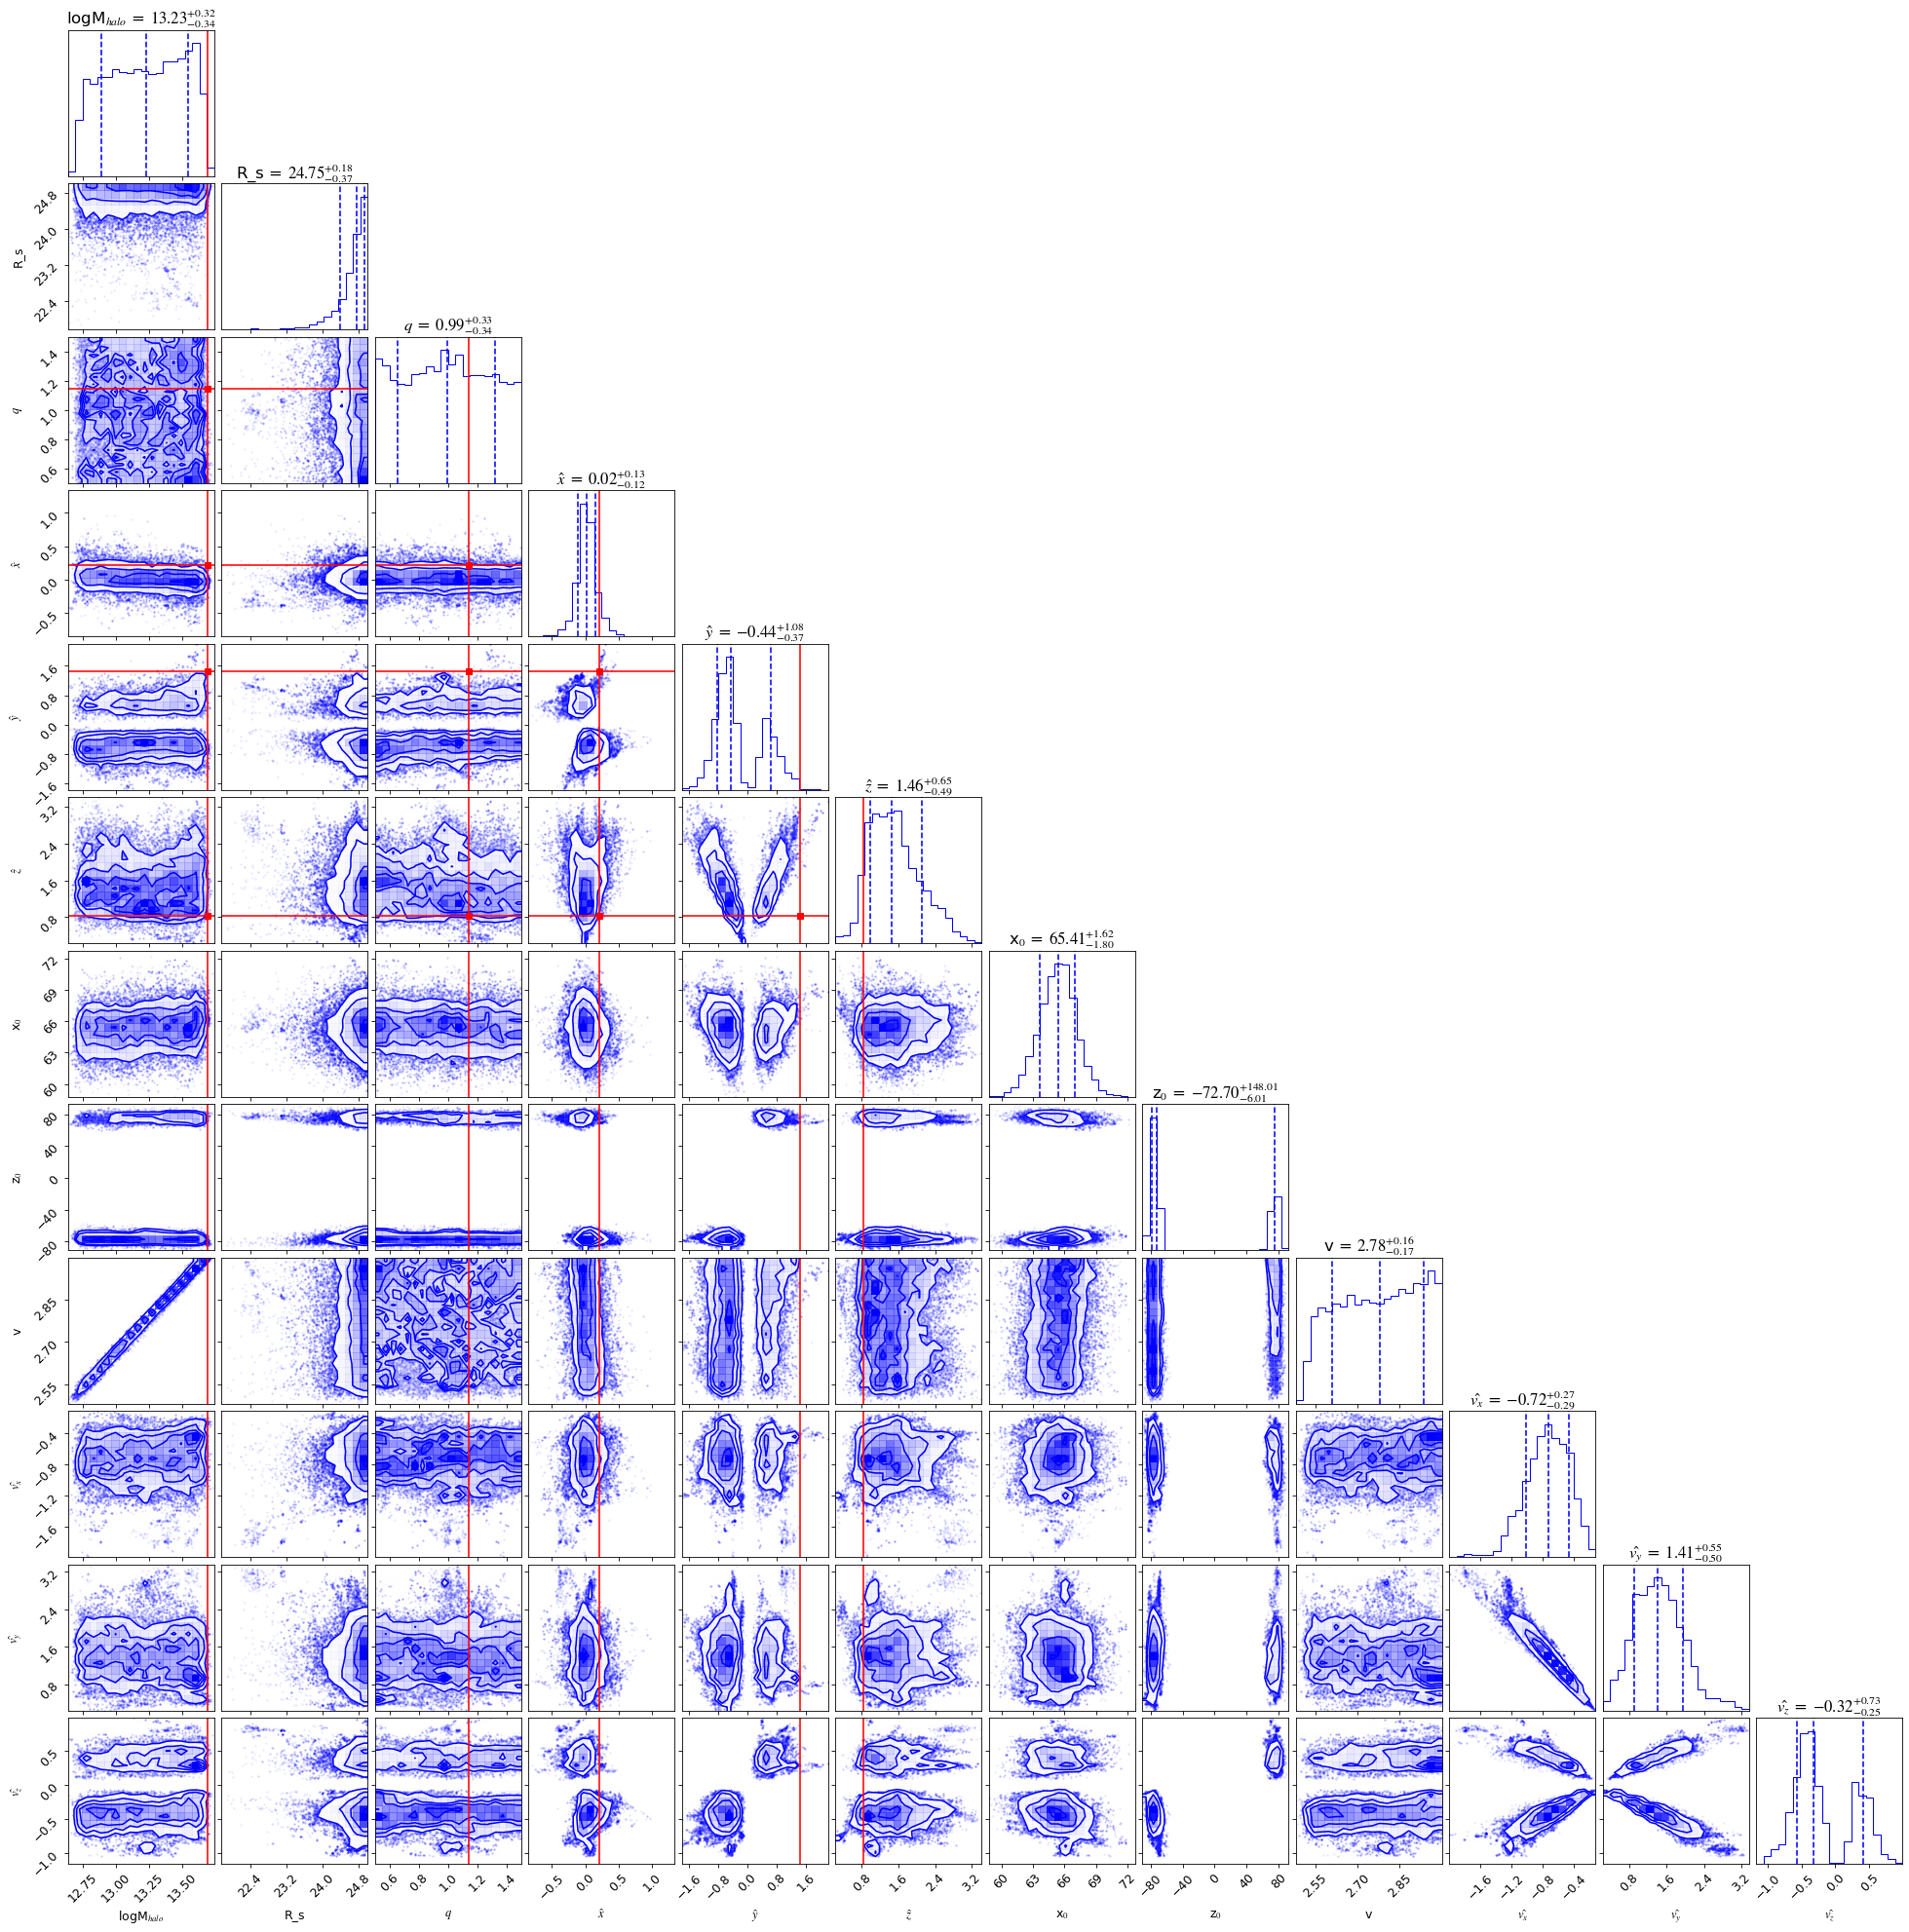

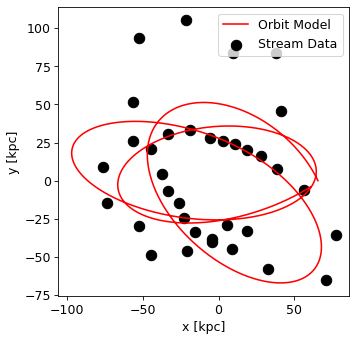

In [16]:
from corner_plots import *
labels=[r'logM$_{halo}$', r'R_s', r'$q$', r'$\hat{x}$', r'$\hat{y}$', r'$\hat{z}$', 
                                r'x$_0$', r'z$_0$', r'v', r'$\hat{v_x}$', r'$\hat{v_y}$', r'$\hat{v_z}$']
ground_truth = np.concatenate([params_data[:6], np.zeros(6)+np.nan])    

figure = corner.corner(dict_result['samps'], 
            labels=labels,
            color='blue',
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True, 
            title_kwargs={"fontsize": 16},
            truths=ground_truth, 
            truth_color='red')


plt.figure(figsize=(5, 5))
plt.xlabel(r'x [kpc]')
plt.ylabel(r'y [kpc]')
xyz_model, xyz_prog = model_info['model'](dict_result['samps'][np.argmax(dict_result['logl'])], theta_initial=0)
x_model, y_model = xyz_model[:,0], xyz_model[:,1]
plt.plot(x_model, y_model, color='red', label='Orbit Model')
plt.scatter(dict_data['x'], dict_data['y'], s=100, color='k', label='Stream Data')
plt.legend(loc='best')

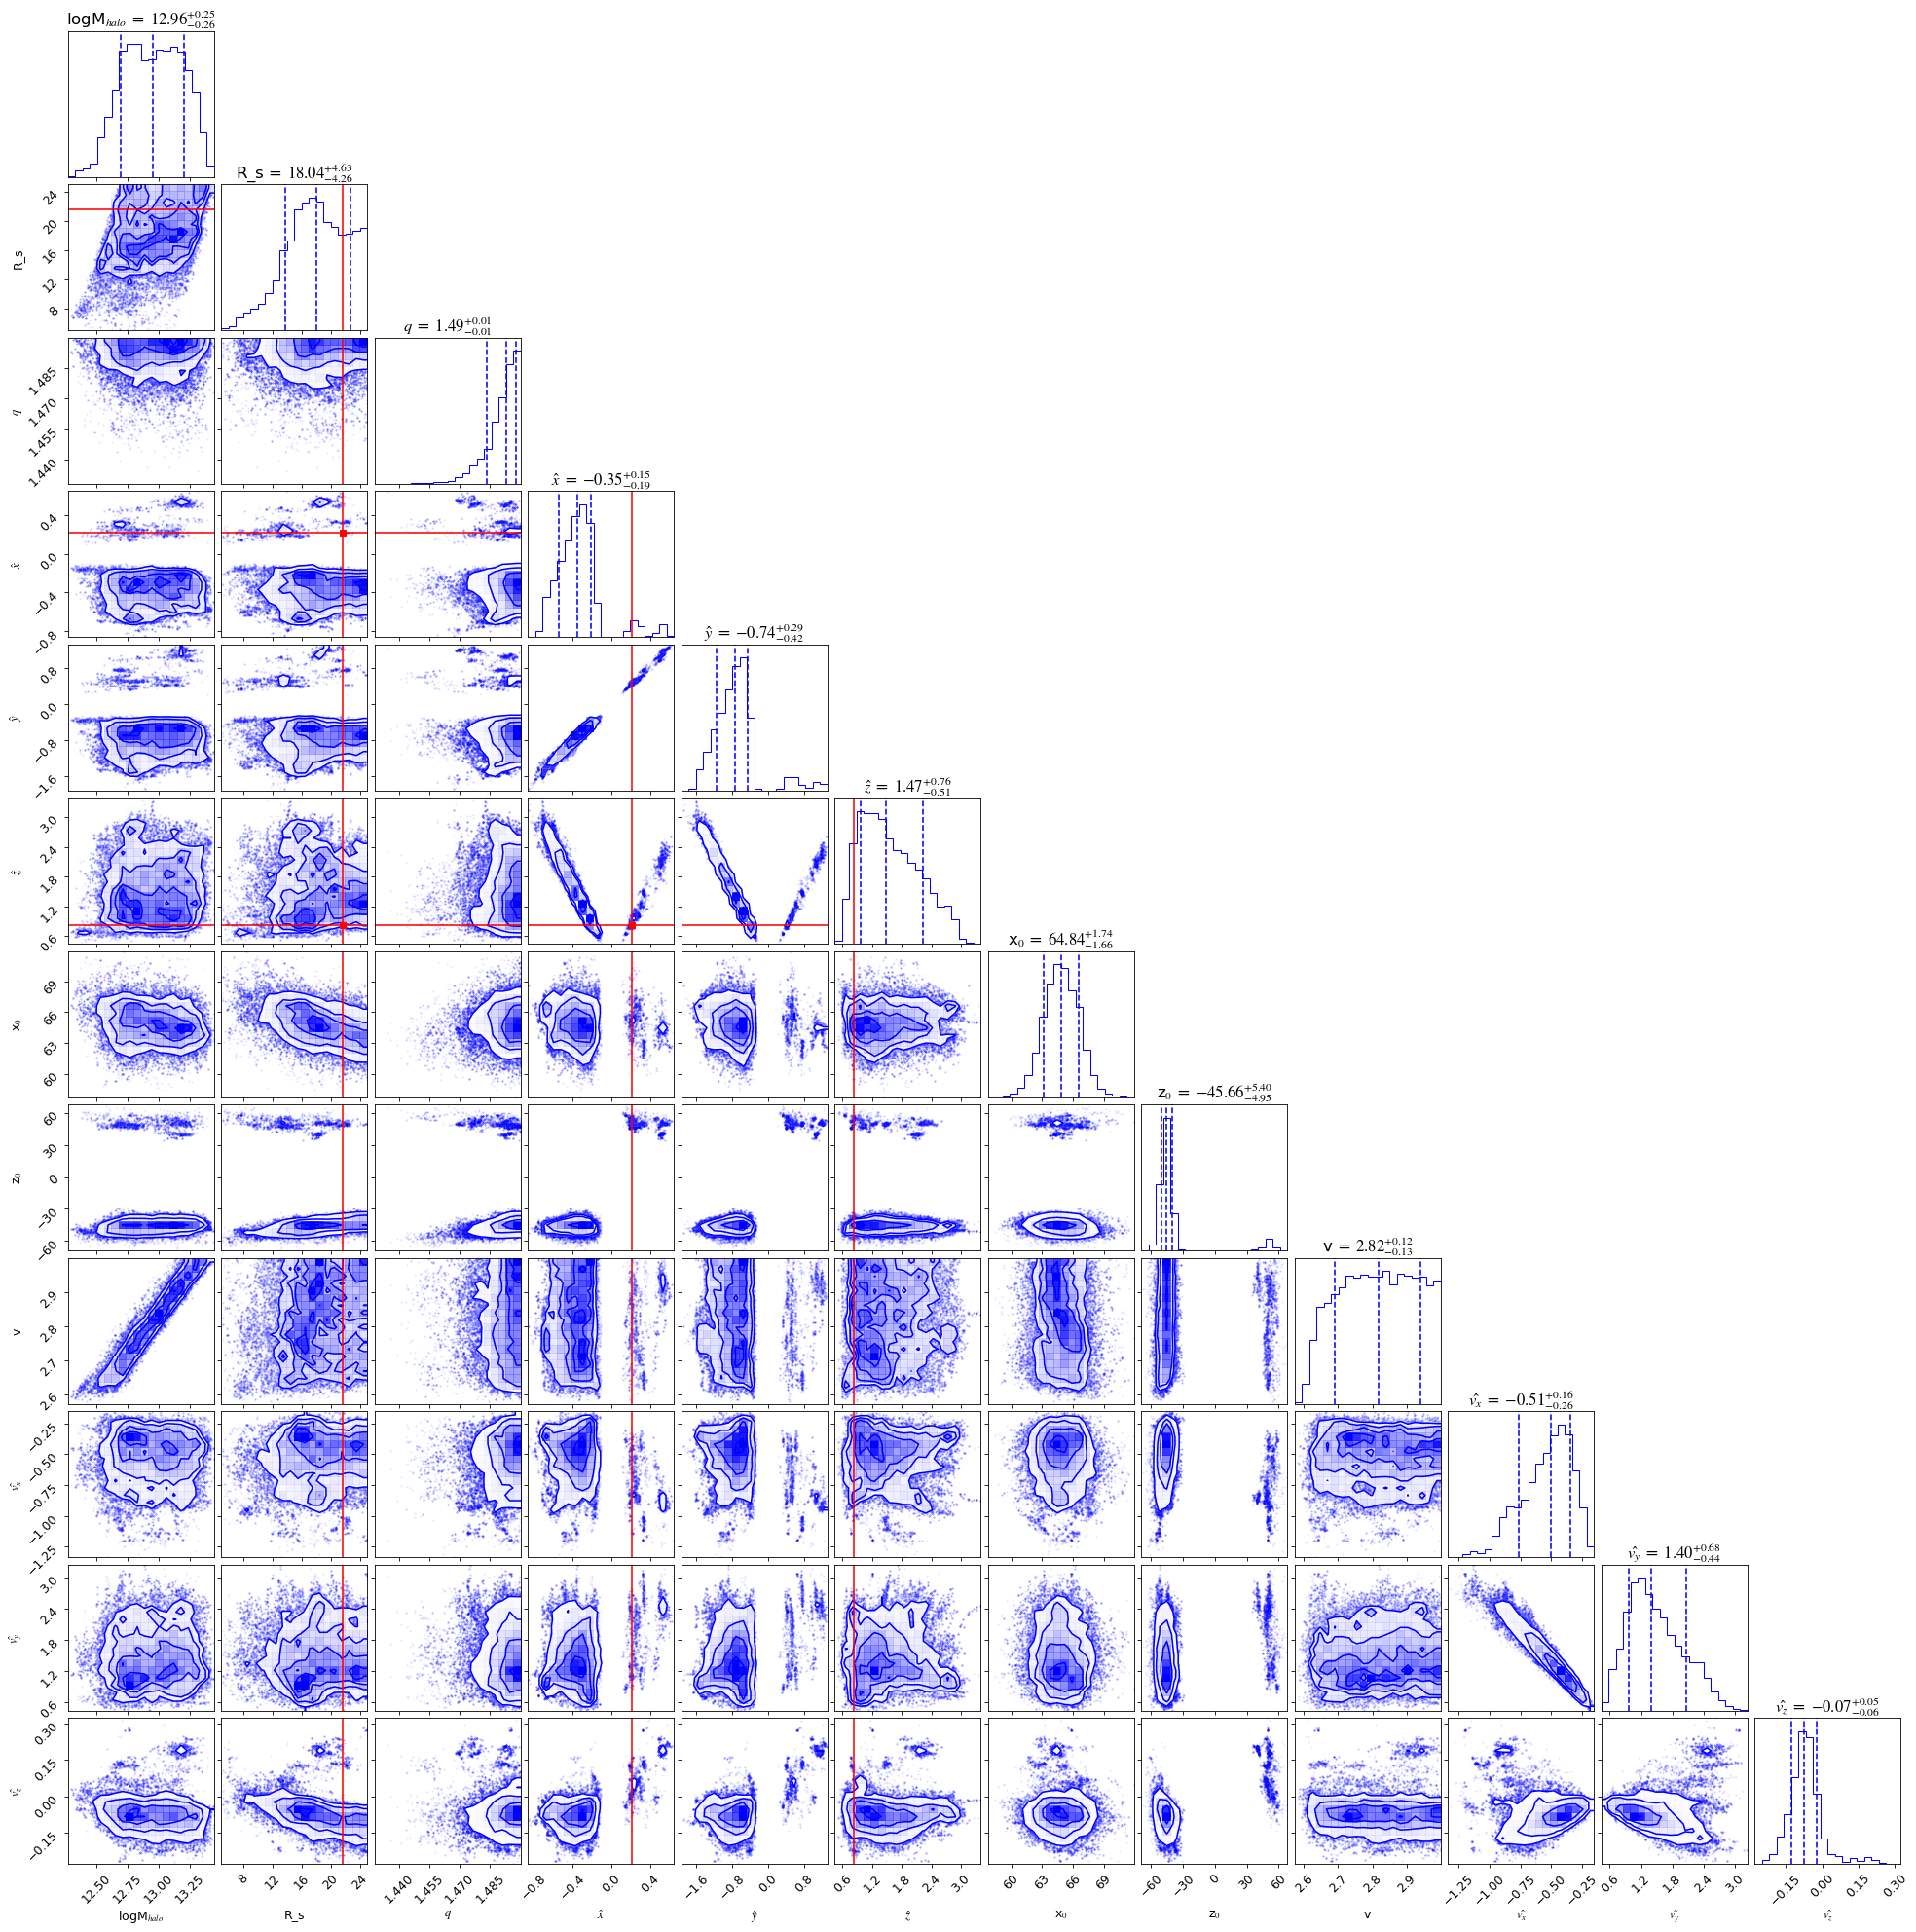

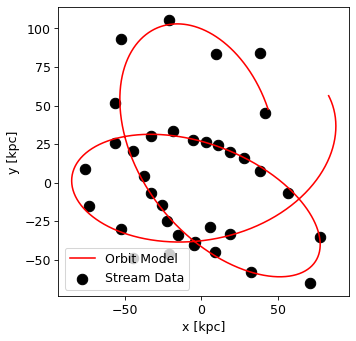

In [55]:
from corner_plots import *
labels=[r'logM$_{halo}$', r'R_s', r'$q$', r'$\hat{x}$', r'$\hat{y}$', r'$\hat{z}$', 
                                r'x$_0$', r'z$_0$', r'v', r'$\hat{v_x}$', r'$\hat{v_y}$', r'$\hat{v_z}$']
ground_truth = np.concatenate([params_data[:6], np.zeros(6)+np.nan])    

figure = corner.corner(dict_result['samps'], 
            labels=labels,
            color='blue',
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True, 
            title_kwargs={"fontsize": 16},
            truths=ground_truth, 
            truth_color='red')


plt.figure(figsize=(5, 5))
plt.xlabel(r'x [kpc]')
plt.ylabel(r'y [kpc]')
xyz_model, xyz_prog = model_info['model'](dict_result['samps'][np.argmax(dict_result['logl'])], theta_initial=theta_initial)
x_model, y_model = xyz_model[:,0], xyz_model[:,1]
plt.plot(x_model, y_model, color='red', label='Orbit Model')
plt.scatter(dict_data['x'], dict_data['y'], s=100, color='k', label='Stream Data')
plt.legend(loc='best')